In [1]:
#드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install konlpy --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 9.5 MB/s eta 0:00:00


In [3]:
!pip install nltk --q

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

import re
from konlpy.tag import Komoran
import numpy as np
from collections import Counter

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer, BertModel
from sklearn.feature_extraction.text import TfidfVectorizer
import torch



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## 데이터 불러오기

In [80]:
path = "/content/drive/MyDrive/유런 24 여름 방학 프로젝트/최종 데이터셋/test_final.csv"

df = pd.read_csv(path)

In [81]:
df.head()

,title,label
0,[국제교류팀] 계약직원 모집,1
1,24-2학기 강사 추가 채용,0
2,현대해상 마음한글 글샘 모집,1
3,[국제교류팀] 2025학년도 1학기 파견 국제교류 프로그램 선발 안내,1
4,2024학년도 2학기 국민대학교 창업동아리 모집 안내(~8/21),1


In [82]:
#label 값에 null값 확인
df['label'].isnull().sum()

0

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   976 non-null    object
 1   label   976 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.4+ KB


## eda

**1) 결측치 확인+중복제거**

In [84]:
print(df[df.duplicated()])

                                                 title  label
51                    「2024 대구정원박람회」 학생정원 참여작품 모집공모 안내      1
144                   영상정보처리기기(CCTV) 설치에 따른 의견수렴(행정예고)      0
148                              [미래차SW인력양성사업단] 연구원 모집      1
153                   영상정보처리기기(CCTV) 설치에 따른 의견수렴(행정예고)      0
271                    서울대학교 수의과대학 자체직원(기간제) 수의사 채용 공고      1
..                                                 ...    ...
953                    S-INNOVATION 창업보육센터 신규입주기업 모집공고      0
964                         서울대학교 융합과학기술대학원 DYROS 로봇스쿨      1
965                           서울대학교 DYROS 로보틱스 부트캠프 안내      1
966                    S-INNOVATION 창업보육센터 신규입주기업 모집공고      0
967  2020학년도 관악학생생활관 학부재학생(재학생,휴학생등) 신청예정자 한국장학재단 소...      0

[63 rows x 2 columns]


In [85]:
df.drop_duplicates(inplace = True)

In [86]:
df

,title,label
0,[국제교류팀] 계약직원 모집,1
1,24-2학기 강사 추가 채용,0
2,현대해상 마음한글 글샘 모집,1
3,[국제교류팀] 2025학년도 1학기 파견 국제교류 프로그램 선발 안내,1
4,2024학년도 2학기 국민대학교 창업동아리 모집 안내(~8/21),1
...,...,...
971,제9회「서울대학교 사회봉사상」후보 추천 공고,1
972,제12회「서울대학교 발전공로상」후보 추천 공고,1
973,2019학년도 융합과학기술대학원 신입생 후기모집,0
974,제73회 전기 학위수여식 및 2019학년도 입학식 안내,0


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 913 entries, 0 to 975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   913 non-null    object
 1   label   913 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 21.4+ KB


**2) class의 균형성 확인**

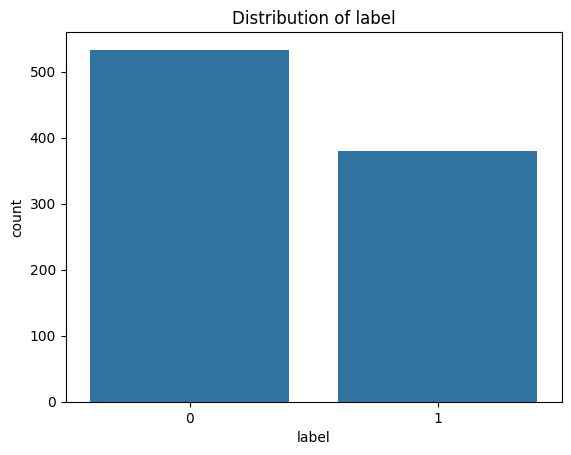

In [88]:
#label 분포 확인
sns.countplot(x='label', data=df)
plt.title('Distribution of label')
plt.show()

In [89]:
df['label'].value_counts()

,count
label,
0,533
1,380


## 전처리

In [90]:
#영문자와 한글만 title에 남기기

df['title'] = df['title'].str.replace('[^a-z|A-Z|ㄱ-ㅎ|가-힣|]', ' ', regex = True)

In [91]:
# 영어와 한국어가 섞여 있으므로 구분할 수 있도록
eng = re.compile(r'[a-zA-Z]')

In [92]:
# lambda 함수를 사용해서 text의 탐지된 x를 lowercase로 바꿔준다.
def lowercase(text):
    return re.sub(r'[a-zA-Z]', lambda x: x.group().lower(), text)

In [93]:
df['title'] = df['title'].apply(lowercase)

In [94]:
# 형태소 분석 및 불용어 제거 함수

def preprocess(text):
    #text = re.sub(r"\s+", " ", text).strip()  불필요한 공백 제거
    #text = text.replace('만료', '')
    #불용어 제거
    stop_words = ['의','가','이','은','들','는','걍','과','들','과','으로','도','을',
                 '를','으로','자','에','와','한','하다','에서','에게', '및', '연도', '년',
                 '년도', '학기', 'ㄴ' '학년도', '회', '상반기', '하반기', '년대', '학년',
                 '오후', '오전', '오늘', '내일', '회차', '개월', '주년', '종료', 'th', 'st', 'nd', "'s", '접수', '기한', '연장',
                  '월', '어', '다', '까지', '제', '등', '등등', '몇', '면', '각', '각각', '마감','공통', '만료',
                  '여', '대', '백양']

    komoran = Komoran(userdic = '/content/drive/MyDrive/유런 24 여름 방학 프로젝트/eda&전처리/user_dictionary.txt')
    lemmatizer = WordNetLemmatizer()

    token_list = []

    for sentence in text :
       sentence = sentence.strip()
       if not sentence:
           token_list.append('')
           continue

       words = sentence.split()
       sentense_list = []

       for word in words :
          if eng.match(word) :
              tokens_word = word_tokenize(word)
              tokens_pos = pos_tag(tokens_word)
              for w, pos in tokens_pos:
                  if pos.startswith('N'):
                      lemma = lemmatizer.lemmatize(w, pos='n')
                  elif pos.startswith('V'):
                      lemma = lemmatizer.lemmatize(w, pos='v')
                  elif pos.startswith('J'):
                      lemma = lemmatizer.lemmatize(w, pos='a')
                  elif pos.startswith('R'):
                      lemma = lemmatizer.lemmatize(w, pos='r')
                  else :
                      continue
                  sentense_list.append(lemma)

          else :
              nouns = komoran.nouns(word)
              sentense_list.extend(nouns)
       token = [t for t in sentense_list if t not in stop_words]
       token_list.append(' '.join(token))
    return token_list

In [95]:
df['processed_title'] = preprocess(df['title'])

In [96]:
df

,title,label,processed_title
0,국제교류팀 계약직원 모집,1,국제 교류 팀 계약직원 모집
1,학기 강사 추가 채용,0,강사 추가 채용
2,현대해상 마음한글 글샘 모집,1,현대해상 마음 한글 글 샘 모집
3,국제교류팀 학년도 학기 파견 국제교류 프로그램 선발 안내,1,국제 교류 팀 파견 국제 교류 프로그램 선발 안내
4,학년도 학기 국민대학교 창업동아리 모집 안내,1,국민대학교 창업 동아리 모집 안내
...,...,...,...
971,제 회 서울대학교 사회봉사상 후보 추천 공고,1,서울대학교 사회봉사 후보 추천 공고
972,제 회 서울대학교 발전공로상 후보 추천 공고,1,서울대학교 발전 공로상 후보 추천 공고
973,학년도 융합과학기술대학원 신입생 후기모집,0,융합과학 기술대학 원 신입생 후기 모집
974,제 회 전기 학위수여식 및 학년도 입학식 안내,0,전기 학위 수여식 입학식 안내


In [97]:
# 한 글자 단어를 제거하되 "팀"과 "랩" 단어는 유지하는 함수

def remove_single_characters(text):
    words = text.split()
    filtered_words = [word for word in words if len(word) > 1 or word in ['팀', '랩']]
    return ' '.join(filtered_words)

df['processed_title'] = df['processed_title'].apply(remove_single_characters)

In [98]:
df.head()

,title,label,processed_title
0,국제교류팀 계약직원 모집,1,국제 교류 팀 계약직원 모집
1,학기 강사 추가 채용,0,강사 추가 채용
2,현대해상 마음한글 글샘 모집,1,현대해상 마음 한글 모집
3,국제교류팀 학년도 학기 파견 국제교류 프로그램 선발 안내,1,국제 교류 팀 파견 국제 교류 프로그램 선발 안내
4,학년도 학기 국민대학교 창업동아리 모집 안내,1,국민대학교 창업 동아리 모집 안내


In [99]:
df.to_csv('test_preprocessing_final.csv', index=False, encoding='utf-8-sig')